## Calculating NDVI  For Whole London

In [2]:
import numpy as np
from sys import argv
from osgeo import gdal, gdalconst


b4 = "/home/vivek/Documents/mydata/iimb/satellite_images/Satellite/1997/Landsat5/LT05_L1TP_201024_19971025_20161229_01_T1_B3.TIF"
b5 = "/home/vivek/Documents/mydata/iimb/satellite_images/Satellite/1997/Landsat5/LT05_L1TP_201024_19971025_20161229_01_T1_B4.TIF"

# Type for internal calculations:
t = np.float32

red = gdal.Open(b4)
nir = gdal.Open(b5)

geotiff = gdal.GetDriverByName('GTiff')

# Ugly syntax, but fast:
r = red.GetRasterBand(1).ReadAsArray(0, 0, red.RasterXSize, red.RasterYSize)
n = nir.GetRasterBand(1).ReadAsArray(0, 0, nir.RasterXSize, nir.RasterYSize)

# Convert the 16-bit Landsat 8 values to floats for the division operation:
r = r.astype(t)
n = n.astype(t)

# Tell numpy not to complain about division by 0:
np.seterr(invalid='ignore')

# Here's the meat of this whole thing, the actual NDVI formula:
ndvi = (n - r)/(n + r)

# The ndvi value is in the range -1..1, but we want it to be displayable, so:
# Make the value positive and scale it back up to the 16-bit range:
#ndvi = (ndvi + 1) * (2**15 - 1)

# And do the type conversion back:
ndvi = ndvi.astype(np.float32)

# output.GetRasterBand(0).WriteArray(ndvi)

## Plotting NDVI

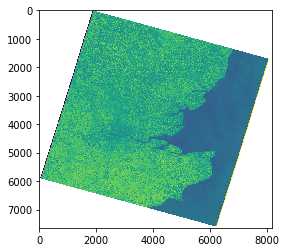

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(ndvi)
plt.show()

In [50]:
# Define spatial characteristics of output object (basically they are analog to the input)
import rasterio
b4 = "/home/vivek/Documents/mydata/iimb/satellite_images/Satellite/1997/Landsat5/LT05_L1TP_201024_19971025_20161229_01_T1_B3.TIF"

with rasterio.open(b4) as src:
    b4 = src.read(1)


kwargs = src.meta

# Update kwargs (change in data type)
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Let's see what is in there
print (kwargs)

with rasterio.open('/home/vivek/Documents/mydata/iimb/satellite_images/Satellite/1997/Landsat5/ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 8191, 'height': 7641, 'count': 1, 'crs': CRS({'init': 'epsg:32631'}), 'transform': Affine(30.0, 0.0, 206985.0,
       0.0, -30.0, 5842515.0)}


## Reading In Calculated NDVI Tiff

In [52]:
import rasterio
import numpy

ndviFilePath = '/home/vivek/Documents/mydata/iimb/satellite_images/Satellite/1997/Landsat5/ndvi.tif'
# We handle the connections with "with"
dataset = rasterio.open(ndviFilePath)
band1 = dataset.read(1)

In [53]:
dataset.bounds

BoundingBox(left=206985.0, bottom=5613285.0, right=452715.0, top=5842515.0)

In [54]:
dataset.crs

CRS({'init': 'epsg:32631'})

## Utilities To Calculate Boundary Pixels

In [55]:
import pyproj
from pyproj import Proj, transform

row_min= 0
row_max = band1.shape[0]
col_min = 0
col_max = band1.shape[1]

def get_crs(long,lat):
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:32631')
    x, y = pyproj.transform(inProj, outProj, long, lat)
    return x,y

def get_corner_pixels(x,y,dataset,band1):
    left_top_x,left_top_y = dataset.index(x-250, y+250)
    right_top_x,right_top_y = dataset.index(x+250, y+250)
    left_bottom_x,left_bottom_y = dataset.index(x-250, y-250)
    right_bottom_x,right_bottom_y = dataset.index(x+250, y-250)
    
    if left_top_x<row_min:left_top_x=row_min
    if left_top_y<col_min:left_top_y=col_min
        
    if right_top_x>row_max:right_top_x=row_max
    if right_top_y<col_min:right_top_y=col_min
        
    if left_bottom_x<row_min:left_bottom_x=row_min
    if left_bottom_y>col_max:left_bottom_y=col_max
        
    if right_bottom_x>row_max:right_bottom_x=row_max
    if right_bottom_y>col_max:right_bottom_y=col_max
        
    ndviSub = band1[left_top_x:left_bottom_x+1,left_top_y:right_top_y+1]
    return ndviSub

## Calculating NDVI For All Post Codes

In [10]:
import pandas
import numpy as np

In [11]:
postCodes = pandas.read_csv("/home/vivek/Documents/mydata/iimb/google_places_details/google_places_complete_with_missing.csv")

In [ ]:
ndviList = []
for row in postCodes.itertuples():
    try:
        x,y = get_crs(row[3],row[2])
        sub = get_corner_pixels(x,y,dataset,band1)
        flat_list = np.array([item for sublist in sub.tolist() for item in sublist])
        water_zone = len(flat_list[(flat_list >= -1) & (flat_list <= 0)])
        barren_land = len(flat_list[(flat_list > 0) & (flat_list <= 0.2)])
        grass_land = len(flat_list[(flat_list > 0.2) & (flat_list <= 0.4)])
        dense_trees = len(flat_list[(flat_list > 0.4) & (flat_list <= 0.7)])
        forest = len(flat_list[(flat_list > 0.7) & (flat_list <= 1)])
        ndviDict={"post_code":row[1],"latitude":row[2],"longitude":row[3],"ndvi_max":np.nanmax(sub),\
                  "ndvi_min":np.nanmin(sub),"ndvi_mean":np.nanmean(sub),"ndvi_median":np.nanmedian(sub),\
                 "water_zone":water_zone,"barren_land":barren_land,"grass_land":grass_land,"dense_trees":dense_trees,\
                 "forest":forest,"yearBetween":19972002}
        ndviList.append(ndviDict)
    except Exception as e:
        #continue
        print (row[1],e)

In [58]:
ndviFrame = pandas.DataFrame(ndviList)
ndviFrame.to_csv("ndvi_19972002.csv",index=False)
ndviFrame.head()

,barren_land,dense_trees,forest,grass_land,latitude,longitude,ndvi_max,ndvi_mean,ndvi_median,ndvi_min,post_code,water_zone,yearBetween
0,62,62,0,182,51.632263,-0.167468,0.565217,0.296781,0.300000,0.045455,N20 9AQ,0,19972002
1,117,0,0,10,51.493689,-0.083037,0.240000,0.021141,0.000000,-0.086957,SE1 4HG,162,19972002
2,98,2,0,8,51.500845,-0.102202,0.423077,0.001872,-0.023256,-0.125000,SE1 0RD,198,19972002
3,147,6,0,152,51.607944,-0.192724,0.446809,0.206653,0.200000,0.000000,N3 1AE,1,19972002
4,180,0,0,23,51.516236,-0.209472,0.304348,0.059501,0.052632,-0.111111,W11 1PN,103,19972002


## Haversine Calculation (Distance From London Center To Post Codes)

In [11]:
# from math import radians, sin, cos, sqrt, asin
 
# def haversine1(lat1, lon1, lat2, lon2):
 
#     R = 6372.8 # Earth radius in kilometers

#     dLat = radians(lat2 - lat1)
#     dLon = radians(lon2 - lon1)
#     lat1 = radians(lat1)
#     lat2 = radians(lat2)

#     a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
#     c = 2*asin(sqrt(a))

#     return R * c

import pandas
from haversine import haversine

center = (51.511500,-0.116000)
data = pandas.read_csv("/home/vivek/Documents/mydata/iimb/satellite_images/ndvi.csv")
haversineList = []
for row in data.itertuples():
    #print (row[2],row[3])
    haversineDict = {"post_code":row[-2],"latitude":row[5],"longitude":row[6],"haversine_distance": haversine(center,(row[5],row[6]))}
    haversineList.append(haversineDict)
haversineFrame = pandas.DataFrame(haversineList)
haversineFrame.to_csv("/home/vivek/Documents/mydata/iimb/satellite_images/haversine.csv",index=False)